<a href="https://colab.research.google.com/github/joshbrx/biomath_model/blob/main/Voronoi_cells_prototipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __Modelo de células con distribución espacial__

---

Import stantard libraries for plotting and necessary libraries from `SciPy`

In [7]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random 
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.collections import LineCollection

from matplotlib.patches import Polygon
import imageio                                          # create an animation (.gif)
import timeit

mycolor = mpl.colormaps["summer"].resampled(100)
mpl.rcParams['figure.figsize'] = (10,6)
plt.style.use('dark_background')

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
def vpoint_to_xy(vor, index):
    return vor.points[index]

def vpoint_to_region(vor, index):
    return vor.point_region[index]

def region_to_vpoint(vor, index):
    return np.where(vor.point_region == index)[0][0]

In [10]:
def vpoints_to_regions(vor, vpoints):
    regions = []
    for i in vpoints:
        regions.append(vpoint_to_region(vor, i))
    return regions

def regions_to_vpoints(vor, regions):
    vpoints = []
    for i in regions:
        vpoints.append(region_to_vpoint(vor, i))
    return vpoints

Ahora continuamos al definir las fronteras de nuestra superficie. Como queremos que se asemeje a una estructura acinar, utilizamos dos secciones cónicas concéntricas (circunferencia o elipse) a la mitad para la aproximación.

\begin{align}
    \alpha(r, \theta, \varepsilon) = \frac{r}{1+\varepsilon\sin\theta},\qquad\ \theta\in{(0, \pi)},\quad  r=\{1, 2\},\quad  \varepsilon \in [0, 1)
\end{align}

\begin{align}
    x &= r\cos\theta,\quad &y &= r\sin\theta\\
    \Rightarrow r &= \sqrt{x^2+y^2},\quad &\theta &= \arctan\left(\frac{y}{x}\right)
\end{align}

**Revisar notas**
<!-- Donde el área entre las dos secciones cónicas, cuya una ecentricidad definida $0\leq\varepsilon < 1$, está dada por:

\begin{align*} 
    A(e) &= (r^2_{\max}-r^2_{\min})\int_{r_\min}^{r_\max} \frac{d\theta}{1+\varepsilon\sin\theta} \\ 
    &= \frac{2(r^2_{\max}-r^2_{\min})}{\alpha}\left[\lim_{\theta\to\pi^+}\arctan\left( \frac{\varepsilon + \tan\left(\frac{\theta}{2}\right)}{\alpha}\right) - \arctan\left( \frac{\varepsilon }{\alpha}\right)\right] \\
    &= \frac{2(r^2_{\max}-r^2_{\min})}{\alpha}\left[\frac{\pi}{2} - \arctan\left( \frac{\varepsilon }{\alpha}\right)\right],\qquad \alpha = \sqrt{1-\varepsilon^2}
\end{align*} -->

Por lo tanto, si consideramos $e=0$ (una circunferencia) tenemos que el área es

$$A_0 =\frac{\pi(r^2_{\max}-r^2_{\min})}{2}$$

Y finalmente al considerar los dos tramos rectangulares que conectan con la estructura de medias circunferencias concéntricas se tiene un área total $A_T$ daba por:

$$A_{T} = \frac{(r_{\max}-r_{\min})\left[\pi(r_{\max}+r_{\min})+4l\right]}{2}$$

In [11]:
def A_total(r, l, rows=1):
    Delta_r = r[1] - r[0]
    r_lower, r_upper = np.mean(r) - Delta_r/2*(1/(rows+1)), np.mean(r) + Delta_r/2*(1/(rows+1))
    A_cells = (r_upper - r_lower)*(np.pi*(r_lower + r_upper) + 4*l)/2
    return A_cells

A_total([1,2], 0, rows=1)

2.356194490192345

Ahora, al considerar a los parámetros $r_{max}$ y $r_{min}$ fijos ($l$ variable) se tiene que

$$ dA_T = \frac{(r_{max}-r_{min})}{1+ \text{# filas}} dl = \frac{A_T}{N}=\langle A_{cell} \rangle $$

Por lo tanto, se alargará $l$ en $l + dl$ en la siguiente proporción para el caso de una sola fila. 

$$ dl = \frac{2\langle A_{cell} \rangle}{(r_{max}-r_{min})}$$

In [12]:
### parámetros
np.random.seed(7)
tol = 0.02; n_space = 100; l = 0
theta = np.array([0, np.pi]);
r = np.array([1.0, 2.0]);

### funciones
alpha_x = lambda r, theta, e: r*np.cos(theta)/(1 + e*np.sin(theta));
alpha_y = lambda r, theta, e: r*np.sin(theta)/(1 + e*np.sin(theta));

In [13]:
def half_donut(r, theta, e, n_space, tol=0.2):
    X_border, Y_border = [], []
    X_border.append(np.concatenate((alpha_x(r[0] + tol*(-1), np.linspace(theta[0], theta[1], n_space//3), e),
                                    alpha_x(r[1] + tol, np.linspace(theta[0], theta[1], n_space),e)), axis=0))
    Y_border.append(np.concatenate((alpha_y(r[0] + tol*(-1), np.linspace(theta[0], theta[1], n_space//3), e), 
                                    alpha_y(r[1] + tol, np.linspace(theta[0], theta[1], n_space),e)), axis=0))
    X_border = np.array(X_border).flatten(); Y_border = np.array(Y_border).flatten(); pts_border = np.array([X_border, Y_border])
    return pts_border

def tunnels(r, l, n_space, tol=0.2):
    X_tunnel, Y_tunnel = [], []
    for i in range(2):
        X_tunnel.append(np.concatenate((np.ones(n_space)*r[i] + tol*(-1)**(i+1),
                                        -np.ones(n_space)*r[i] - tol*(-1)**(i+1), np.linspace(r[0]-tol,
                                        r[1]+tol, num=n_space)*(-1)**(i)), axis=0))
        Y_tunnel.append(np.concatenate((np.linspace(0,-l, num=n_space), np.linspace(0,-l, num=n_space),
                                        -np.ones(n_space)*l), axis=0))
    X_tunnel = np.array(X_tunnel).flatten(); Y_tunnel = np.array(Y_tunnel).flatten(); pts_tunnel = np.array([X_tunnel, Y_tunnel])
    return pts_tunnel

def get_structure(r, theta, e, l, n_space, tol=0.2):
    donut = half_donut(r, theta, e, n_space, tol=tol)
    tunnel = tunnels(r, l, n_space//8, tol=tol)
    pts_structure = np.concatenate((donut, tunnel), axis=1)
    return pts_structure

def rand_points(r, theta, e, N, tol=0.02):
    r_rand     = np.random.rand(N) * abs(r[-1]-r[0]-2*tol) + r[0] + tol
    theta_rand = np.random.rand(N) * abs(theta[1]-theta[0]) + theta[0]
    X_rand = alpha_x(r_rand, theta_rand, e); Y_rand = alpha_y(r_rand, theta_rand, e); pts_rand = np.array([X_rand, Y_rand])
    return pts_rand

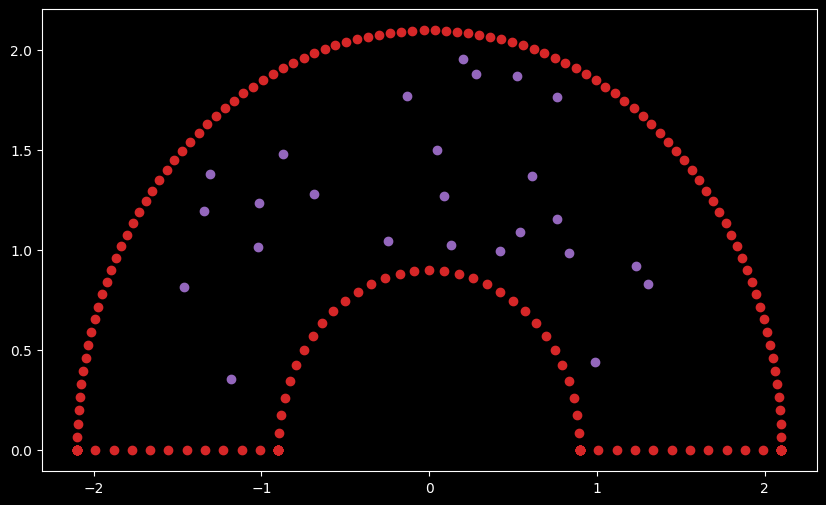

In [14]:
N = 25; tol = 0.1;
e = 0.0

pts_structure = get_structure(r, theta, e, l, n_space, tol=tol)
pts_rand = rand_points(r, theta, e, N, tol=tol/10).T

plt.scatter(pts_rand.T[0], pts_rand.T[1], color="tab:purple")
plt.scatter(pts_structure[0], pts_structure[1], color="tab:red")

In [15]:
def mk_voronoi(points, pts_structure):
    total = np.concatenate((points, pts_structure.T))
    vor = Voronoi(total)
    return vor

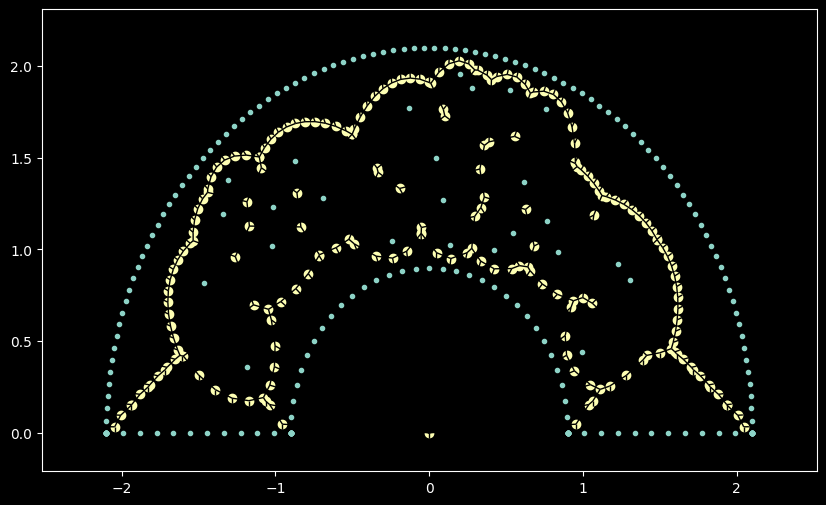

<Figure size 1500x700 with 0 Axes>

In [16]:
vor = mk_voronoi(pts_rand, pts_structure)

voronoi_plot_2d(vor)
plt.figure(figsize=(15,7)); plt.show()

*   ###  __Paso $N+1$:__ _Encontrando y discriminando las regiones de Voronoi_



In [17]:
# vor.ridge_dict

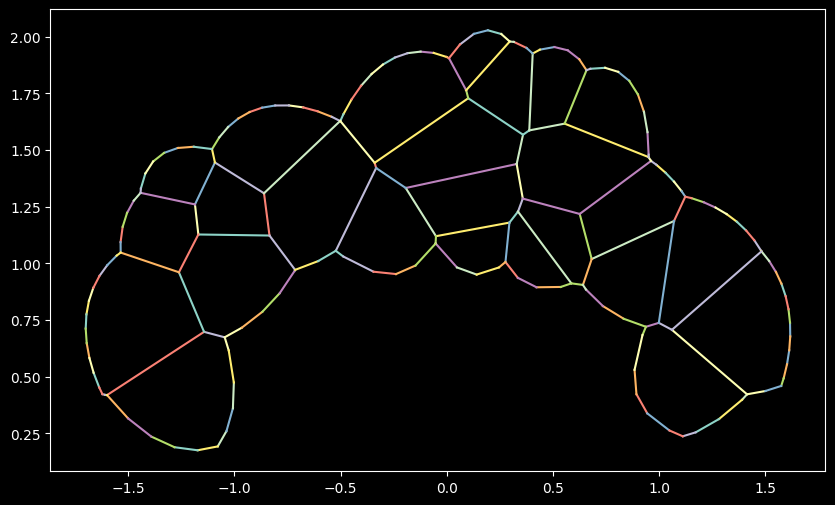

In [18]:
finite_segments = []
temp_dict = vor.ridge_dict
temp_keys = temp_dict.keys()

for key in temp_keys:
    if np.all(np.asarray(temp_dict[key]) >= 0) and np.any(np.asarray(key) < len(pts_rand)):
        finite_segments.append(vor.vertices[np.asarray(temp_dict[key])])

for i in range(len(finite_segments)):
    x_line = finite_segments[i][:,0]
    y_line = finite_segments[i][:,1]
    plt.plot(x_line, y_line)

In [19]:
def get_polygons(vor, N_points):
    Polygons, regions = [], []
    nregions = len(vor.regions)
    for i in range(len(vor.regions)):
        if (not -1 in vor.regions[i]) and (len(vor.regions[i]) >=1):
            polygon = np.array([vor.vertices[k] for k in vor.regions[i]])
            Polygons.append(np.array([*zip(*polygon)]))
            regions.append(i)
    vpoints = regions_to_vpoints(vor, regions)
    Polygons = [np.array(x) for _,x in sorted(zip(vpoints, Polygons))][:N_points]
    return Polygons

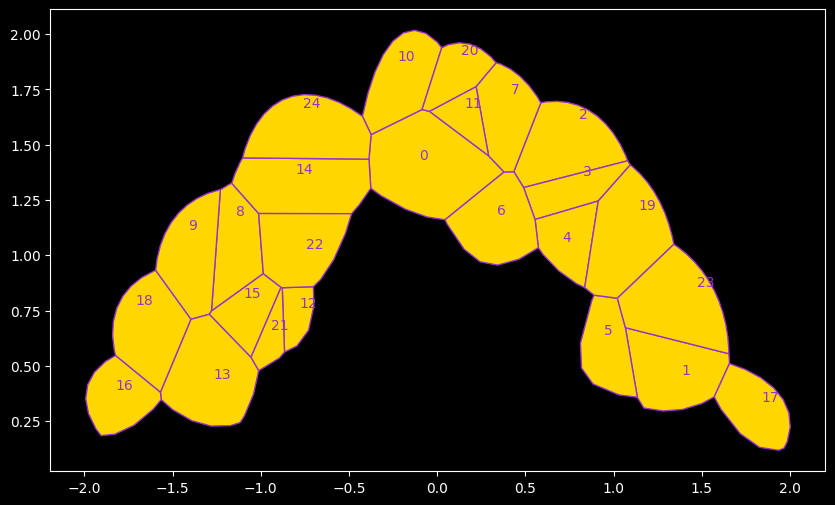

In [20]:
points = rand_points(r, theta, e, N, tol=0.02).T                          # make up data points
vor = mk_voronoi(points, pts_structure)                                 # compute Voronoi tesselation

N_points = len(points)                                                
Polygons = get_polygons(vor, N_points)                                  # get Voronoi regions

for i in range(len(Polygons)):                                          # visualize Voronoi regions
    polygon = Polygons[i]
    X, Y = polygon
    plt.text(np.mean(X), np.mean(Y) + 0.05, f"{i}", color="darkorchid")
    plt.fill(X, Y, edgecolor="darkorchid", facecolor="gold")
plt.show()

In [21]:
len(Polygons)           # Número de polígonos guardados (coincide con el número de puntos dados)

25


*   ###  __Paso $N+2$:__ _Calculando el área y el centroide de un polígono_

\begin{align}
    A &= \frac{1}{2}\sum_{i=0}^{N-1} (x_iy_{i+1}-x_{i+1}y_i)
\end{align}

Y para el cálculo de las coordenadas del centro de masas en 2D tenemos las siguientes ecuaciones

\begin{align}
    C_x &= \frac{1}{6A}\sum_{i=0}^{N-1}(x_i+x_{i+1})(x_iy_{i+1}-x_{i+1}y_i) \\
    C_y &= \frac{1}{6A}\sum_{i=0}^{N-1}(y_i+y_{i+1})(x_iy_{i+1}-x_{i+1}y_i)
\end{align}

Para mayor información puede consultar el siguiente enlace: [Calculating the area and centroid of a polygon. By Paul Bourke](https://lexrent.eu/wp-content/uploads/torza/artikel_groep_sub_2_docs/BYZ_3_Polygon-Area-and-Centroid.pdf)

-----

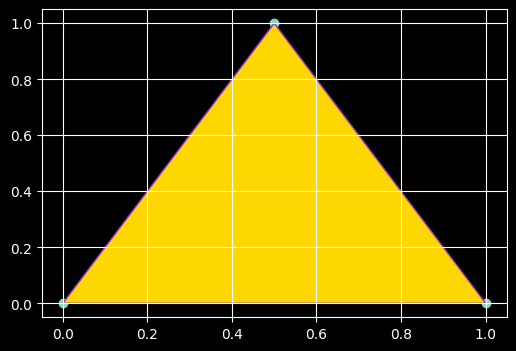

In [22]:
x_prueba = np.array([0,1,0.5])
y_prueba = np.array([0,0,1])

polygon_prueba = np.array([x_prueba, y_prueba])

plt.figure(figsize=(6,4))
plt.scatter(x_prueba, y_prueba); plt.fill(x_prueba, y_prueba, edgecolor="darkorchid", facecolor="gold"); plt.grid()

In [23]:
def area_voronoi(Polygons, index=None):
    if index == None:
        n_regions = len(Polygons)
        X, Y, n_area, S = [], [], [], np.zeros(n_regions)
        for i in range(n_regions):
            X.append(Polygons[i][0])
            Y.append(Polygons[i][1])
            n_area = len(X[i])
            for k in range(n_area):
                S[i] += X[i][k]*Y[i][(k+1) % n_area] - X[i][(k+1) % n_area]*Y[i][k]

    else:
        n_area = Polygons[index].shape[1]
        X, Y = Polygons[index]
        S = 0
        for i in range(n_area):
            S += X[i]*Y[(i+1) % n_area] - X[(i+1) % n_area]*Y[i]
    
    return (1/2)*np.abs(S)

# area_voronoi(Polygons)
timeit.timeit("area_voronoi(Polygons)","from __main__ import area_voronoi, Polygons", number=1000)/1000

0.00028713816300023607

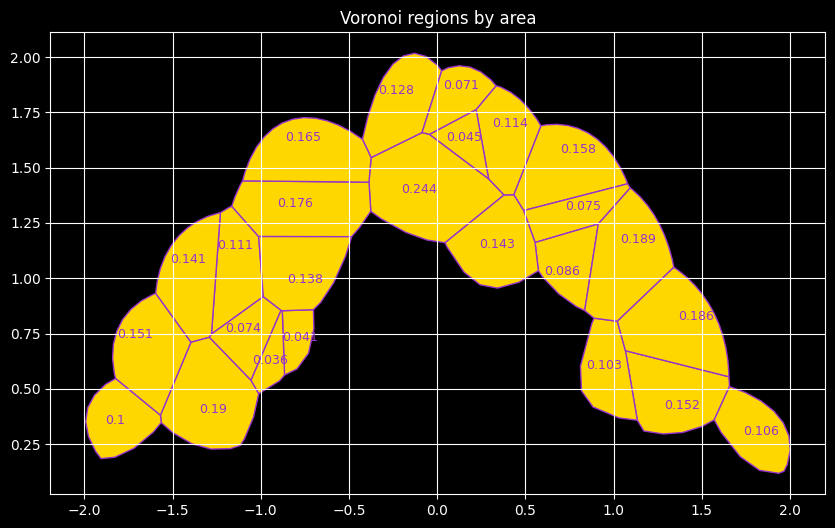

In [24]:
A_vor = area_voronoi(Polygons)

for i in range(len(Polygons)):
    X, Y = Polygons[i]
    num_label = round(A_vor[i], 3)
    plt.text(np.mean(X), np.mean(Y), f'${num_label}$', fontsize=9, horizontalalignment='center',
             color='darkorchid', fontweight='bold')
    plt.fill(X, Y, edgecolor="darkorchid", facecolor="gold")
plt.title("Voronoi regions by area"); plt.grid()

---

Ahora se calcula el centroide de cada polígono

In [25]:
def centroid_voronoi(Polygons, index=None):
    if index == None:
        n_regions = len(Polygons)
        X, Y, CX, CY = [], [], np.zeros(n_regions), np.zeros(n_regions)

        for i in range(n_regions):
            X.append(Polygons[i][0])
            Y.append(Polygons[i][1])
            n_centroid = len(X[i])
            for k in range(n_centroid):
                CX[i] += (X[i][k] + X[i][(k+1) % n_centroid]) * (X[i][k] * Y[i][(k+1) % n_centroid] - X[i][(k+1) % n_centroid]*Y[i][k])
                CY[i] += (Y[i][k] + Y[i][(k+1) % n_centroid]) * (X[i][k] * Y[i][(k+1) % n_centroid] - X[i][(k+1) % n_centroid]*Y[i][k])
        A = area_voronoi(Polygons)
        cX = CX / (6*A)
        cY = CY / (6*A)
        for j in range(n_regions):
            if abs(cX[j] - np.mean(X[j]))  > abs(-cX[j] - np.mean(X[j])):
                cX[j] = -cX[j]
            if abs(cY[j] - np.mean(Y[j]))  > abs(-cY[j] - np.mean(Y[j])):
                cY[j] = -cY[j]

    else:
        n_centroid = Polygons[index].shape[1]
        X, Y = Polygons[index]
        A = area_voronoi(Polygons, index=index)
        CX, CY = np.empty([2, n_centroid])
        
        for i in range(n_centroid):
            CX[i] = (X[i] + X[(i+1) % n_centroid]) * (X[i] * Y[(i+1) % n_centroid] - X[(i+1) % n_centroid]*Y[i])
            CY[i] = (Y[i] + Y[(i+1) % n_centroid]) * (X[i] * Y[(i+1) % n_centroid] - X[(i+1) % n_centroid]*Y[i])
        
        cX, cY = (np.sum(CX), np.sum(CY))/(6*A) 
        if abs(cX - np.mean(X)) > abs(-cX - np.mean(X)):
            cX = -cX
        if abs(cY - np.mean(Y)) > abs(-cY - np.mean(Y)):
            cY = -cY
    return np.array([cX, cY])

# centroid_voronoi(Polygons)
# timeit.timeit("centroid_voronoi(Polygons, index=1)", globals=globals(), number=2000)/2000
# timeit.timeit("centroid_voronoi(Polygons)", globals=globals(), number=2000)/2000

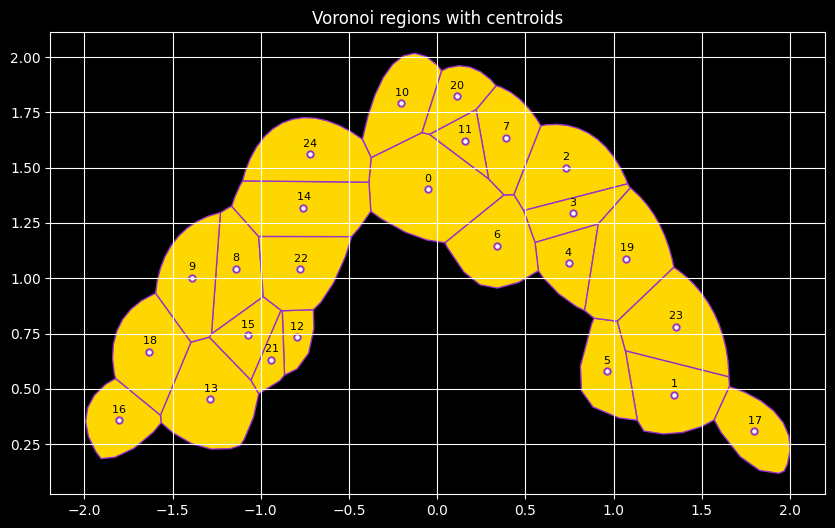

In [26]:
C_vor = centroid_voronoi(Polygons);
fig, ax = plt.subplots();

for i in range(len(Polygons)):
    X, Y = Polygons[i]
    num_label = round(area_voronoi(Polygons, index=i), 3)
    plt.text(C_vor[0][i], C_vor[1][i]+0.035, f'${i}$', fontsize=8, horizontalalignment='center', color='black', fontweight='bold')
    ax.fill(X, Y, zorder=-2, edgecolor="darkorchid", facecolor="gold")
ax.scatter(C_vor[0], C_vor[1], color="darkorchid", zorder=1, s=25)
ax.scatter(C_vor[0], C_vor[1], color="azure", zorder=2, s=5)
plt.title("Voronoi regions with centroids"); plt.grid()

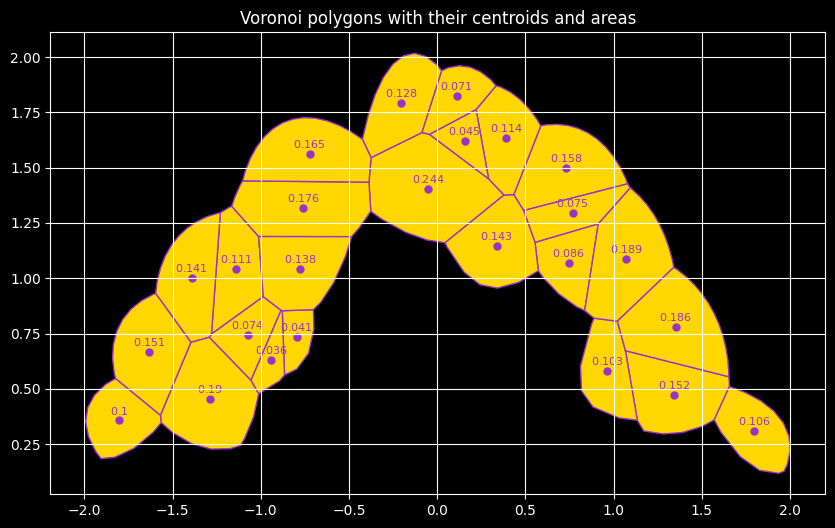

In [27]:
A_vor = area_voronoi(Polygons);
C_vor = centroid_voronoi(Polygons);

for i in range(len(Polygons)):
    X, Y = Polygons[i]
    num_label = round(A_vor[i], 3)
    plt.text(C_vor[0][i], C_vor[1][i]+0.027, f'${num_label}$', fontsize=8, horizontalalignment='center',
             color='darkorchid', fontweight='bold', zorder=1)
    plt.fill(X, Y, zorder=-2, edgecolor="darkorchid", facecolor="gold")
plt.scatter(C_vor[0], C_vor[1], color="darkorchid", zorder=-1, s=25); ax.scatter(C_vor[0], C_vor[1], color="azure", zorder=0, s=5)
plt.title("Voronoi polygons with their centroids and areas")
plt.grid()

*   ###  __Paso $N+3$:__ _Definiendo las interacciones y evolución del sistema a partir del potencial $V(\vec{x},t)$_

\begin{align}
    V(\vec{r_i}, t) = \frac{K_v}{2}\left(A_i(t)-A_0(t)\right)^2 + \frac{K_c}{2}\big|\vec{r}_i(t) - \vec{r}_{0,i}(t)\big|^2 
\end{align}

donde $A_0 = \sum_{i=1}^N(A_i/N)$

[Cell Patterns Emerge from Coupled Chemical and Physical Fields with Cell Proliferation Dynamics: The Arabidopsis thaliana Root as a Study System](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3642054/)

In [28]:
def dist_vor(vor_points, C_vor, index=None):
    if index==None:
        cX, cY = C_vor
        X, Y = vor_points[:C_vor.shape[1]].T
        dist = (X - cX)**2 + (Y - cY)**2
    else:
        cX, cY = C_vor.T[index]
        X, Y = vor_points[index]
        dist = (X - cX)**2 + (Y - cY)**2
    return dist

# dist_vor(vor.points, C_vor)
timeit.timeit("dist_vor(vor.points, C_vor)", globals=globals(), number=2000)/2000

1.2433915499968862e-05

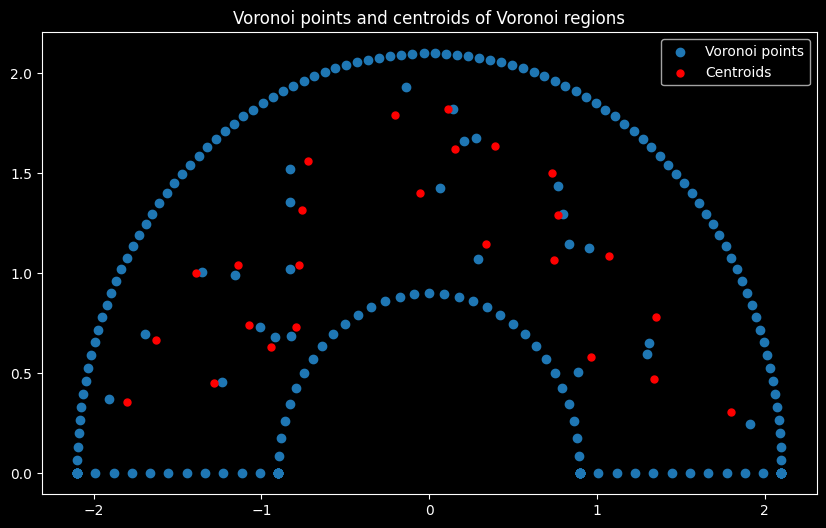

In [29]:
plt.figure(figsize=(10,6))
plt.scatter(vor.points.T[0], vor.points.T[1], color="tab:blue", label="Voronoi points")
plt.scatter(C_vor[0], C_vor[1], color="red", s=25, label="Centroids")
plt.title("Voronoi points and centroids of Voronoi regions"); plt.legend()

In [30]:
K = [0.5, 0.5, 0.5]
A_0 = (np.pi/2)*(r[1]**2 - r[0]**2)/len(Polygons)

def potential_vor(K, vor_points, A_vor, C_vor, A_mean=None):
    if A_mean == None:
        A_mean = np.mean(A_vor)
    v1 = K[0]/2 * (A_vor - A_mean)**2
    v2 = K[1]/2 * dist_vor(vor_points, C_vor)
    return v1 + v2

# potential_vor(K, vor.points, A_vor, C_vor)
# timeit.timeit("potential_vor(K, vor.points, A_vor, C_vor)", globals=globals(), number=50000)/50000
# 4.197351130002062e-05

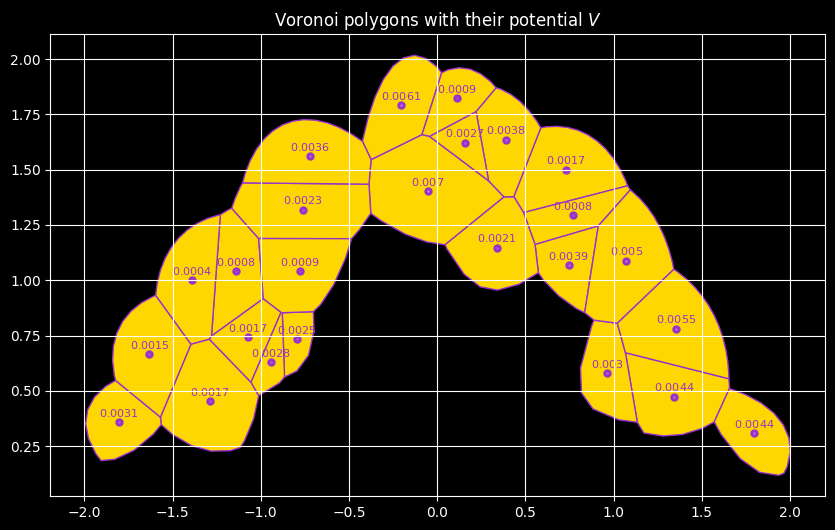

In [31]:
V_vor = potential_vor(K, vor.points, A_vor, C_vor)

for i in range(len(Polygons)):
    X, Y = Polygons[i]
    num_label = round(V_vor[i], 4)
    plt.text(C_vor[0,i], C_vor[1,i]+0.025, f'${num_label}$', fontsize=np.sqrt(V_vor[i])+8,
             horizontalalignment='center', color='darkorchid', fontweight='bold', zorder=1)
    plt.fill(X, Y, zorder=-2, edgecolor="darkorchid", facecolor="gold")
    plt.scatter(C_vor[0,i], C_vor[1,i], color="azure", zorder=0, s=V_vor[i]*10)

plt.scatter(C_vor[0], C_vor[1], color="darkorchid", zorder=-1, s=25); 
plt.title("Voronoi polygons with their potential $V$")
plt.grid()

\begin{align}
    F_x(x_i, t) = &-\frac{K_v}{2}\left[\frac{1}{2}\sum_{m=1}^{M} \frac{(x_i-x_m)\cdot l_{i,m}}{|\vec{r}_i-\vec{r}_m|}\{A_i - A_0\}\right]\\
                  &- K_c(x_i-x_{0,i})\\
    F_y(y_i, t) = &-\frac{K_v}{2}\left[\frac{1}{2}\sum_{m=1}^{M} \frac{(y_i-y_m)\cdot l_{i,m}}{|\vec{r}_i-\vec{r}_m|}\{A_i - A_0\}\right]\\
                  &- K_c(y_i-y_{0,i})  
\end{align}

In [32]:
def get_lines(vor, N_points):
    line_segments, line_regions, vor_surface = [], [], []
    for simplex, pointidx in zip(vor.ridge_vertices, vor.ridge_points):
        if -1 not in simplex:
            pointidx = np.asarray(pointidx)
            simplex = np.asarray(simplex)
            if np.any(pointidx <= N_points - 1):
                if np.any(pointidx > N_points - 1):
                    a, _ = np.sort(pointidx)
                    vor_surface.append(a)
                else:
                    line_segments.append(vor.vertices[simplex])
                    line_regions.append(pointidx)

    line_segments = np.array(line_segments)
    line_regions = np.array(line_regions)
    vor_surface = np.array(list(set(vor_surface)))
    return line_segments, line_regions, vor_surface

# get_lines(vor, N)[2]
# timeit.timeit("get_lines(vor, N)", globals=globals(), number=5000)/5000

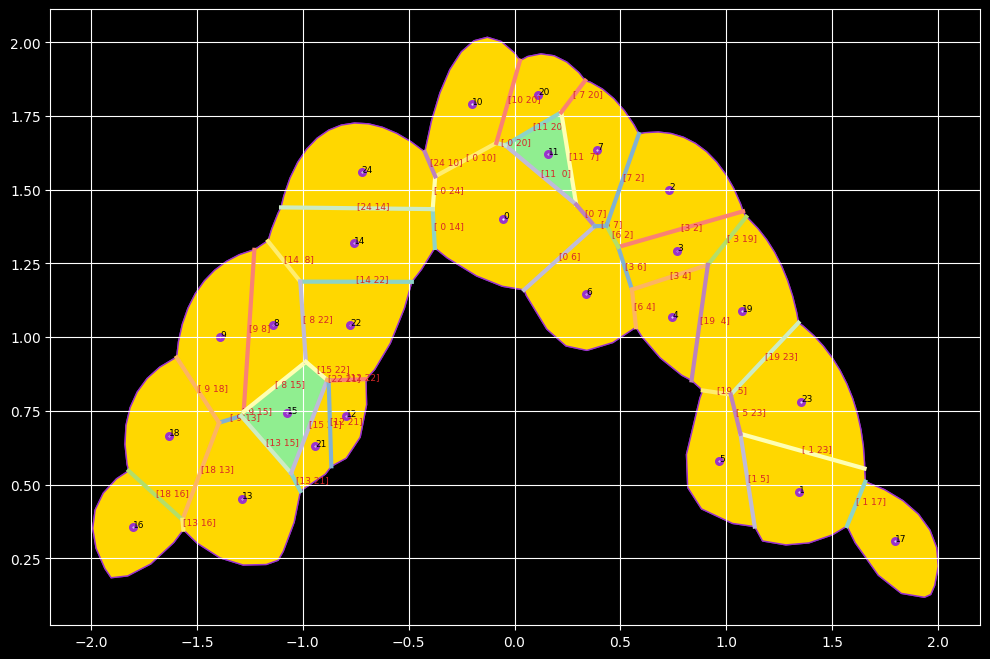

In [33]:
line_segments, line_regions, vor_surface = get_lines(vor, N)
plt.figure(figsize=(12,8))

for i in range(len(line_segments)):                                 # Plot shared lines 
    line_segment = line_segments[i]
    x_line = line_segment[:,0]
    y_line = line_segment[:,1]
    plt.plot(x_line, y_line, linewidth=3)
    plt.text(np.mean(x_line), np.mean(y_line), f"{line_regions[i]}", color="tab:red", zorder=2, fontsize=6.5)

for i in range(len(Polygons)):                                      # Visualize Voronoi regions
    X, Y = Polygons[i]
    plt.fill(X, Y, zorder=-3, edgecolor="darkorchid", facecolor="lightgreen")
    plt.text(C_vor[0][i], C_vor[1][i], f"{i}", color="black", zorder=0, fontsize=6.5)
    plt.scatter(C_vor[0][i], C_vor[1][i], color="azure", zorder=0, s=V_vor[i]*50)

for i in vor_surface:                                              # Plot shared lines 
    X, Y = Polygons[i]
    plt.fill(X, Y, zorder=-3, edgecolor="darkorchid", facecolor="gold")

plt.scatter(C_vor[0], C_vor[1], color="darkorchid", zorder=-1, s=30); 
plt.grid()

In [34]:
def get_dist_dict(vor, N_points):
    dist_dict = {}
    line_segments, line_regions, vor_surface = get_lines(vor, N_points)
    for k in range(len(line_regions)):
        i, m = sorted(line_regions[k])
        d = np.sum((line_segments[k][0] - line_segments[k][1])**2)
        dist_dict[(i,m)] = d
    return dist_dict, vor_surface

dist_dict, vor_surface = get_dist_dict(vor, N)

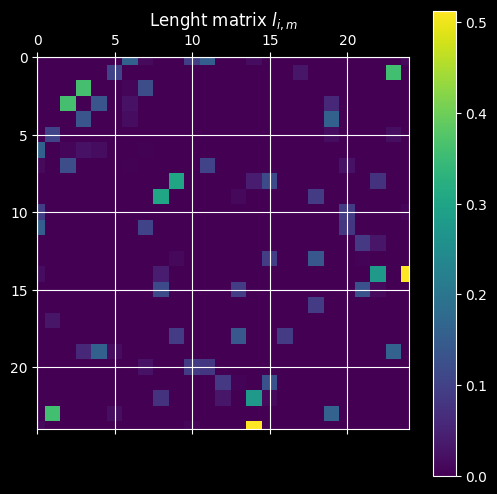

In [35]:
s = (N, N)
empty_matrix = np.zeros(s)
for k in range(len(line_regions)):
    i, m = sorted(line_regions[k])
    d = np.sum((line_segments[k][0] - line_segments[k][1])**2)
    empty_matrix[i,m] += d
    empty_matrix[m,i] += d

plt.matshow(empty_matrix);
plt.xlim([0, N - 1]); plt.ylim([N - 1,0]);
plt.title("Lenght matrix $l_{i,m}$"); plt.colorbar(); plt.grid()

In [36]:
def F(K, X_pts, A_vor, C_vor, dist_dict, i, A_mean=None):
    f, l = np.zeros(2), np.zeros(2)
    if A_mean == None:
        A_mean = np.mean(A_vor)
    area_diff = A_vor - np.mean(A_vor)
    dist_diff = X_pts[i] - C_vor.T[i]
    for key in dist_dict.keys():
        a, b = key
        if (a == i) or (b == i):
            if a == i: pass
            else: b = a
            r_temp = X_pts[i] - X_pts[b]
            l += (dist_dict[key] * r_temp * area_diff[i]) / (np.linalg.norm(r_temp))      # evolución dinámica
    f = -(K[0] * l)/4 - (K[1] * dist_diff)
    return f

# F(K, vor.points, A_vor, C_vor, dist_dict, 1)
# timeit.timeit("F(K, vor.points, A_vor, C_vor, dist_dict, 1)", globals=globals(), number=50000)/50000
# 0.0003678074883999216

In [37]:
def gates(i, b, dist_dict, vor_surface, C_vor):
    value = False;
    i, b = sorted((i, b))
    v1 = (i in vor_surface)
    v2 = (b in vor_surface)
    if (i, b) in dist_dict.keys():
        # v3 = (C_vor[0][i] > C_vor[0][b])      # x_i above x_b
        v3 = (C_vor[0][i] < C_vor[0][b])      # x_i below x_b
        s1 = (v1 and v2 and v3)
        s3 = (not v1) and v2 and v3
        value = s1 or s3
    else:
        value = not (v1 or v2)
    return value

gates(0, 15, dist_dict, vor_surface, C_vor)

False

In [38]:
C, alpha = np.random.rand(N), 0.1

def C_field(K, vor_points, A_vor, C_vor, dist_dict, vor_surface, i, C0, alpha, A_mean=None, state=True):
    dC = 0
    V_field = potential_vor(K, vor_points, A_vor, C_vor, A_mean=A_mean)
    for key in dist_dict.keys():
        a, b = key
        if (a == i) or (b == i):
            if a == i: pass
            else: b = a
            if state == True:
                if gates(i, b, dist_dict, vor_surface, C_vor):
                    c_diff = C0[i] - C0[b]
                    v_diff = abs(V_field[i] - V_field[b])
                    dC += dist_dict[key] * c_diff * v_diff
            else: 
                c_diff = C0[i] - C0[b]
                v_diff = abs(V_field[i] - V_field[b])
                dC += dist_dict[key] * c_diff * v_diff
    dC = alpha * dC
    return dC

C_field(K, vor.points, A_vor, C_vor, dist_dict, vor_surface, 4, C, alpha, state=True)
# timeit.timeit("C_field(K, vor.points, A_vor, C_vor, dist_dict, vor_surface, 4, C, alpha)", globals=globals(), number=5000)/5000

8.14229176018739e-06

In [39]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

(<Figure size 840x560 with 1 Axes>, <Axes: >)

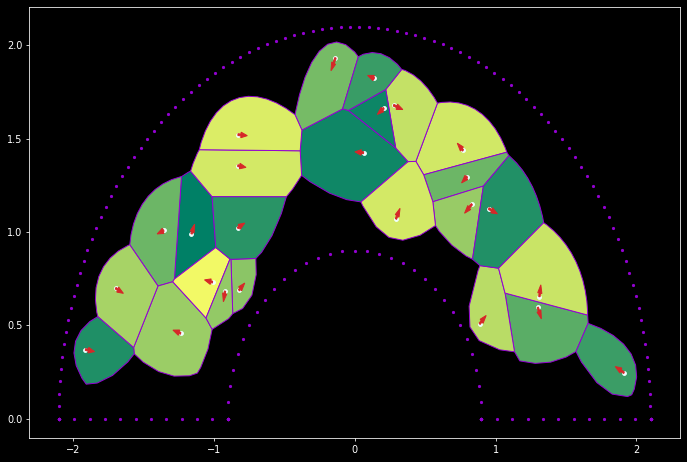

In [40]:
def voronoi_forces(K, vor, A_vor, C_vor, N_points, C0, alpha, V=None, state=True):
    fig, ax = plt.subplots(figsize=(12,8), dpi=70)
    Polygons = get_polygons(vor, N_points)
    dist_dict, vor_surface = get_dist_dict(vor, N_points)

    points = vor.points[:N_points]
    pts_structure = vor.points[N_points:].T
    A_mean = np.mean(A_vor)

    for i in range(N_points):
        X, Y = Polygons[i]
        Fx, Fy = F(K, points, A_vor, C_vor, dist_dict, i, A_mean=A_mean)
        dC = C_field(K, points, A_vor, C_vor, dist_dict, vor_surface, i, C0, alpha, A_mean=A_mean, state=state)
        ax.arrow(points[i][0], vor.points[i][1], Fx, Fy, width = 0.01, color="tab:red")
        if V is not None: 
            ax.arrow(points[i][0], points[i][1], V[0][i], V[1][i], width = 0.001, color="tab:blue")
        ax.fill(X, Y, zorder=-2, edgecolor="darkviolet", facecolor=mycolor(C0[i]))   # rojo = C_alto
    ax.scatter(points.T[0], points.T[1], color="azure", zorder=-1, s=15); 
    ax.scatter(pts_structure[0], pts_structure[1], color="darkviolet", zorder=-1, s=5)
    return fig, ax
    
voronoi_forces([1.9,0.2,0.4], vor, A_vor, C_vor, N, C, alpha, V=None, state=False)
# timeit.timeit("voronoi_forces([1.9,0.2,0.4], vor, A_vor, C_vor, N, C, alpha, V=None);", globals=globals(), number=1)/1

## Evolución del sistema (con transporte de auxinas y división celular)

Suponemos que la concentración de auxinas mantiene un comportamiento periódico en cada célula, por lo que decimos que el periodo de un cíclo auxinar está en función de la concentración de las mismas de la siguiente manera. 

$$ T(c_i) = \beta c_i$$

Entonces también aprovechamos para calcular el cambio del periodo en función de la concentración de auxina.

$$ \frac{dT(c_i)}{dc_i} = \beta $$

Por lo que el cambio en función del tiempo es el siguiente:

$$ \frac{dT(c_i)}{dt} = \beta \frac{dc_i}{dt} $$

In [41]:
def timer_celldiv(dC, C0, T0, beta):
    dT = beta * dC
    return dT

\begin{align}
    \frac{d\vec{r}}{dt} &= \vec{v} \\
    \frac{d\vec{v}}{dt} &= \vec{F}_T \\
    \frac{1}{\alpha}\frac{dc_i}{dt} &= \sum_{m=1}^{M} l_{i,m}(c_i-c_m) |V_i-V_m| \\
    \frac{dT}{dt} &= - \frac{T(\tau)}{2c_i}\qquad\ \text{(Cambio del periodo de las células)}
\end{align}

In [42]:
def dX(K, A_vor, C_vor, dist_dict, vor_surface, X0, C0, T0, alpha, beta, A_mean=None, state=True):    
    X_pts, V_pts = X0[:,0:2], X0[:,2:4]
    N_points = len(T0)
    
    if A_mean == None:
        A_mean = np.median(A_vor)

    dX_ = V_pts                                  # (dx, dy) = (Vx, Vy)
    dV_ = np.zeros(V_pts.shape)                  # (dVx, dVy) = (Fx, Fy)
    dC_ = np.zeros(C0.shape)                     # 1/1alpha * dC[i]
    dT_ = np.zeros(T0.shape)

    for i in range(N_points):
        dV_[i] = F(K, X_pts, A_vor, C_vor, dist_dict, i, A_mean=A_mean) - K[2]*dX_[i]
        dC_[i] = C_field(K, X_pts, A_vor, C_vor, dist_dict, vor_surface, i, C0, alpha, A_mean=A_mean, state=state)
    dT_ = timer_celldiv(dC_, C0, T0, beta)
    dX = np.concatenate([dX_, dV_], axis=1)

    return dX, dC_, dT_

### Proceso de división celular

Primero definimos el proceso de división individual para pasar de una célula a dos células. Se siguen los siguientes pasos:

1. Se avanza el reloj interno $\frac{dT_i}{d\tau}$ de cada célula según la variable $\tau$ del sistema biológico. (Es necesario iniciar previamente $T_i$)
2. Detectar cuales células cumplan el cíclo y resetear su reloj $T_i=0$ después de 
3. En cada una de estas células, agregar un nuevo punto $\vec{r}_j=\vec{r}_i + \vec{r_c}(A_i)$, donde $|r_c|$ suele ser $1/4$ el radio de la célula $i$. 

In [43]:
def cell_division(A_vor, C_vor, X0, C0, T0, beta, gamma, N_div, dt, N_points, pts_structure ,scale=1/3, celldiv=True):
    if N_div*dt > gamma:
        # print("b")
        c_t = 2*np.pi*(beta)**(-1/2)
        T0 = c_t * (C0)**(-1/2)
    else:
        tmp = N_div*dt - T0 > 0
        if (np.any(tmp == True) and celldiv) == True:
            print("Cell division! ", np.sum(tmp), )
            for i in range(N_points):
                if tmp[i]: 
                    print(f"\t Cell number: {i+1}")
                    X0, C0, T0 = new_division(A_vor[i], X0, C0, T0, i, beta, N_points, pts_structure, scale=scale)
            N_points += np.sum(tmp)
            N_div = 0
        
    vor = mk_voronoi(X0[:,0:2], pts_structure)
    Polygons = get_polygons(vor, N_points)
    A_vor = area_voronoi(Polygons)
    C_vor = centroid_voronoi(Polygons);
    
    S = [A_vor, C_vor, X0, C0, T0]
    return S, N_points, vor, Polygons, N_div

In [44]:
def new_division(area, X0, C0, T0, i, beta, N_points, pts_structure, scale=1/3):
    X_pts, V_pts = X0[:,0:2], X0[:,2:4]
    X, V = X_pts[i], V_pts[i]
    r, E, arr = (area/np.pi)**(1/2), np.sum((V**2)/2), np.random.rand(2)
    hat = arr / np.linalg.norm(arr)
    # -----------------------------------------
    dX = r * scale * hat     
    X_pts[i] = X - dX
    X_pts = np.append(X_pts, [X + dX], axis=0)              # se agrega un nuevo punto

    dV = E * hat
    V_pts[i] = V - dV 
    V_pts = np.append(V_pts, [V + dV], axis=0)              # se reparte la energía cinética entre las 2 células

    X0 = np.concatenate([X_pts, V_pts], axis=1)             # se guarda todo en X0
    # -----------------------------------------
    C0[i] /= 2
    C0 = np.append(C0, [C0[i]], axis=0)                     # se reparte la concentración de auxinas entre 2
    # -----------------------------------------
    c_t = 2*np.pi*(beta)**(-1/2)
    T0[i] = c_t * (C0[i])**(-1/2)
    # T0[i] = 0
    T0 = np.append(T0, [T0[i]], axis=0)                     # se reinician los relojes internos
    # -----------------------------------------
    return (X0, C0, T0)

# new_division(np.copy(vor.points[:N]), np.copy(A_vor), 0)[0][-1], new_division(np.copy(vor.points[:N]), np.copy(A_vor), 0)[1][-1]

-------

## Finalmente, evolucionamos el sistema biológico...

In [45]:
def RK_solver(K, vor, X0, C0, T0, params, t, N_points, structure, A_fixed=None, N_div=None, scale=1/4, state=True, celldiv=True):
    alpha, beta, gamma = params
    Polygons = get_polygons(vor, N_points)
    A_vor, C_vor = area_voronoi(Polygons), centroid_voronoi(Polygons);
    dist_dict, surface = get_dist_dict(vor, N_points)

    if A_fixed == None:
        A_fixed = np.median(A_vor)
    if N_div == None:
        N_div = 0
    dt = t[1] - t[0]; 

    for i in range(len(t)):
        rX = np.empty([4, X0.shape[0], X0.shape[1]])
        rC = np.empty([4, C0.shape[0]])
        rT = np.empty([4, T0.shape[0]])

        rX[0],rC[0],rT[0] = dX(K, A_vor, C_vor, dist_dict, surface, X0             , C0             , T0             , alpha, beta, A_mean=A_fixed, state=state)
        rX[1],rC[1],rT[1] = dX(K, A_vor, C_vor, dist_dict, surface, X0 + dt*rX[0]/2, C0 + dt*rC[0]/2, T0 + dt*rT[0]/2, alpha, beta, A_mean=A_fixed, state=state)
        rX[2],rC[2],rT[2] = dX(K, A_vor, C_vor, dist_dict, surface, X0 + dt*rX[1]/2, C0 + dt*rC[1]/2, T0 + dt*rT[1]/2, alpha, beta, A_mean=A_fixed, state=state)
        rX[3],rC[3],rT[3] = dX(K, A_vor, C_vor, dist_dict, surface, X0 + dt*rX[2]  , C0 + dt*rC[2]  , T0 + dt*rT[2]/2, alpha, beta, A_mean=A_fixed, state=state)

        ss_X = rX[0] + 2*rX[1] + 2*rX[2] + rX[3]
        ss_C = rC[0] + 2*rC[1] + 2*rC[2] + rC[3]
        ss_T = rT[0] + 2*rT[1] + 2*rT[2] + rT[3]
        X0 += dt*ss_X/6
        C0 += dt*ss_C/6
        T0 += dt*ss_T/6 - dt

        S, N_points, vor_out, Polygons, N_div = cell_division(A_vor, C_vor, X0, C0, T0, beta, gamma, N_div, dt, N_points, 
                                                              structure, scale=scale, celldiv=celldiv)
        A_vor, C_vor, X0, C0, T0 = S

        dist_dict, surface = get_dist_dict(vor_out, N_points)
        A_fixed = np.mean(area_voronoi(Polygons))
        N_div += 1
    C0 = C0 / np.max(C0)
    return (A_vor, C_vor, X0, C0, T0), (vor_out, Polygons, dist_dict, surface), N_points, N_div

def euler_solver(K, vor, X0, C0, T0, params, t, N_points, structure, A_fixed=None, N_div=None, scale=1/4, state=True, celldiv=True):
    alpha, beta, gamma = params
    Polygons = get_polygons(vor, N_points)
    A_vor, C_vor = area_voronoi(Polygons), centroid_voronoi(Polygons);
    dist_dict, surface = get_dist_dict(vor, N_points)

    if A_fixed == None:
        A_fixed = np.median(area_voronoi(Polygons))
    if N_div == None:
        N_div = 0
    dt = t[1] - t[0]; 

    for i in range(len(t)):
        temp = dX(K, A_vor, C_vor, dist_dict, surface, X0, C0, T0, alpha, beta, A_mean=A_fixed, state=state)
        X0, C0, T0 = X0 + dt*temp[0], C0 + dt*temp[1], T0 + dt*temp[2] - dt

        S, N_points, vor_out, Polygons, N_div = cell_division(A_vor, C_vor, X0, C0, T0, beta, gamma, N_div, dt, N_points, 
                                                              structure, scale=scale, celldiv=celldiv)
        (A_vor, C_vor, X0, C0, T0) = S

        dist_dict, surface = get_dist_dict(vor_out, N_points)
        A_fixed = np.mean(area_voronoi(Polygons))
        N_div += 1
    C0 = C0 / np.max(C0)
    return (A_vor, C_vor, X0, C0, T0), (vor_out, Polygons, dist_dict, surface), N_points, N_div

In [82]:
def evolve_vornonoi(r, theta, l, K, vor, C0, N_points, params, step=0.001, lenght=100, iter=20, vel=(0,0.1), method="RK4", A_fixed=None, scale=1/4, filenames=None, state=True, celldiv=True, l_step=5):
    """
    solver["RK4"]: Runge-Kutta order 4
    solver["Euler"]: Euler method
    """
    T0 = params[1] * C0
    dl = [0,0]
    
    N_div = 0
    if filenames == None:
        filenames = []

    points, structure = vor.points[:N_points], vor.points[N_points:].T
    solver = {"RK4":RK_solver, "Euler":euler_solver}[method]
    
    t = np.arange(0, lenght*step, step)
    X0 = np.concatenate([points, np.random.normal(vel[0], vel[1], points.shape)], axis=1)       # mov. browniano inicial
    X_out, V_out = X0[:,0:2], X0[:,2:4]

    Polygons = get_polygons(vor, N_points)
    dist_dict = get_dist_dict(vor, N_points)
    
    A_vor = area_voronoi(Polygons);
    C_vor = centroid_voronoi(Polygons);

    print("evolve_voronoi: ", N_div*step)
    print("\tT0:", np.min(T0))

    fig, ax = voronoi_forces(K, vor, A_vor, C_vor, N_points, C0, alpha, V=V_out.T)
    kN = N_points/(N_points+1)
    ax.set_title(f"Graph: {0},\t t={0},\t method: {method},\t N={N_points},\t $A_T$={np.round_([np.sum(A_vor), kN*A_total(r, l)], decimals=3)},\t l={l},\t dl={dl}")
    plt.show()

    # filename = f'/content/drive/MyDrive/biomath_model/figures/prueba0.png'          
    # filenames.append(filename)
    # fig.savefig(filename, bbox_inches='tight')

    for i in range(iter):
        S1, S2, N_points, N_div = solver(K, vor, X0, C0, T0, params, t, N_points, structure, A_fixed=A_fixed, 
                                         N_div=N_div, scale=scale, state=state, celldiv=celldiv)
        A_vor, C_vor, X0, C0, T0 = S1
        vor, Polygons, dist_dict, surface = S2
        X_out, V_out = X0[:,0:2], X0[:,2:4]
        
        if dl[1] > 0: 
            l += dl[0] / l_step
            structure = get_structure(r, theta, 0, l, 100, tol=tol)
            vor = mk_voronoi(X0[:,0:2], structure)
            dl[1] -= 1 

        if (i % l_step == 0) and (np.sum(A_vor) * 1.2 >= A_total(r, l, rows=1) * N_points/(N_points+1)):
            dl = [2*A_total(r, l, rows=1)/(N*(r[1]-r[0])), l_step]


        print("evolve_voronoi: ", N_div*step)
        print("\tT0:", np.min(T0))

        fig, ax = voronoi_forces(K, vor, A_vor, C_vor, N_points, C0, params[0], V=V_out.T)
        ax.set_title(f"Graph: {i+1},\t t={round((i+1)*lenght*step, 2)},\t method: {method},\t N={len(T0)},\t $A_T$={np.round_([np.sum(A_vor), kN*A_total(r, l)], decimals=3)},\t l={round(l,2)},\t dl={dl}")
        plt.show()  

        # filename = f'/content/drive/MyDrive/biomath_model/figures/prueba{i+1}.png'          
        # filenames.append(filename)
        # fig.savefig(filename, bbox_inches='tight')
    return vor, C0, N_points

evolve_voronoi:  0.0
	T0: 1.5104441177240968


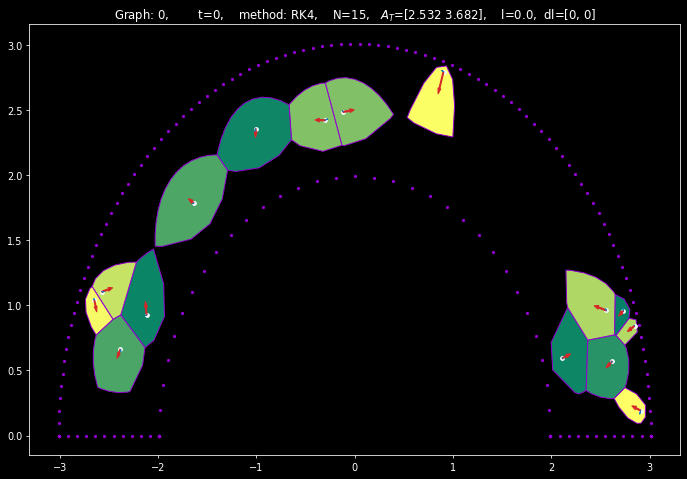

evolve_voronoi:  2.5
	T0: -5.869390135829627


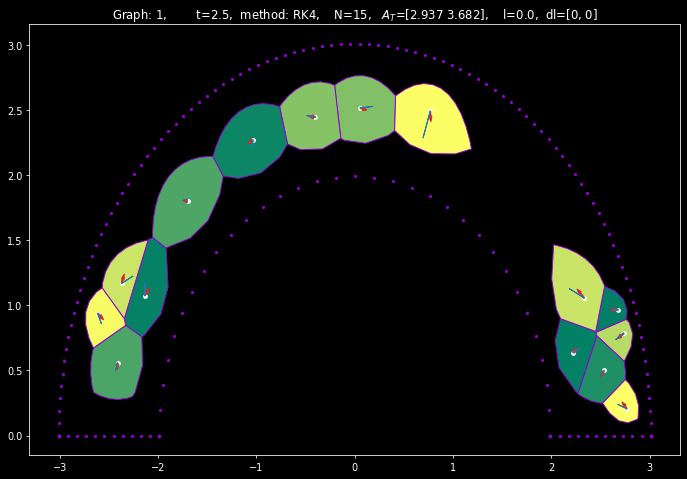

evolve_voronoi:  5.0
	T0: -9.529500243892933


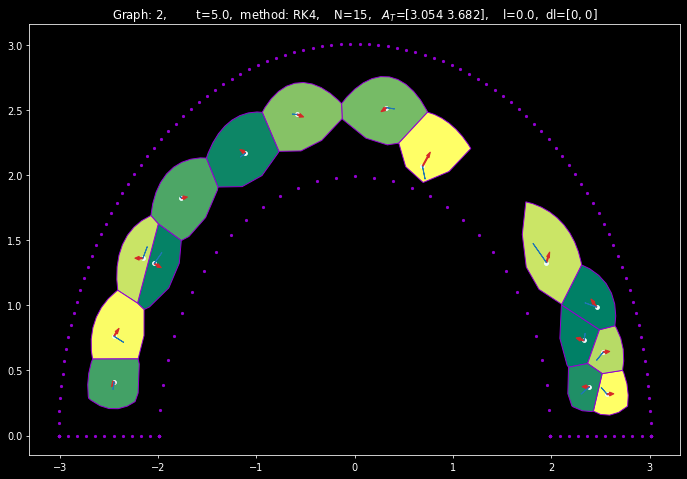

evolve_voronoi:  7.5
	T0: -12.754515642909452


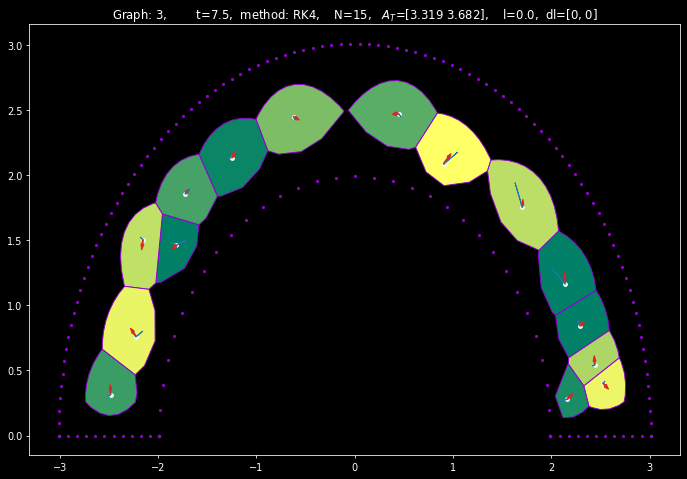

evolve_voronoi:  10.0
	T0: -15.984667541549243


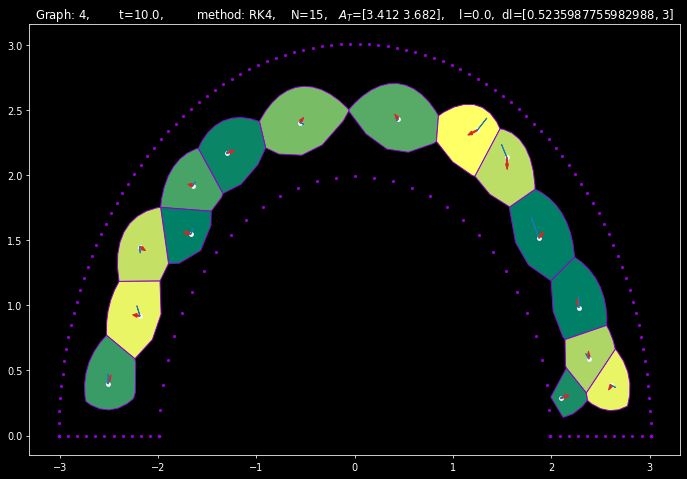

evolve_voronoi:  12.5
	T0: -20.846674059168983


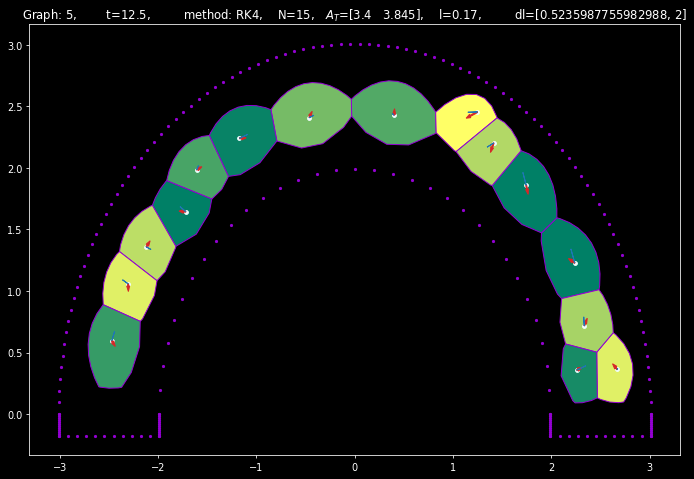

evolve_voronoi:  15.0
	T0: -25.01158460147008


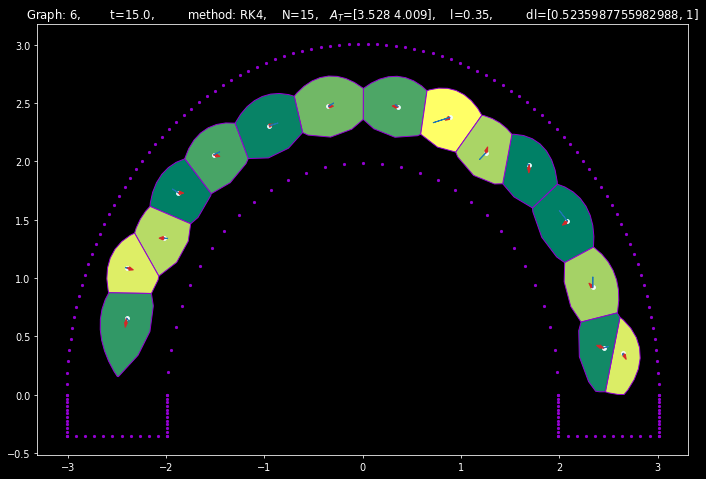

evolve_voronoi:  17.5
	T0: -29.358642254096665


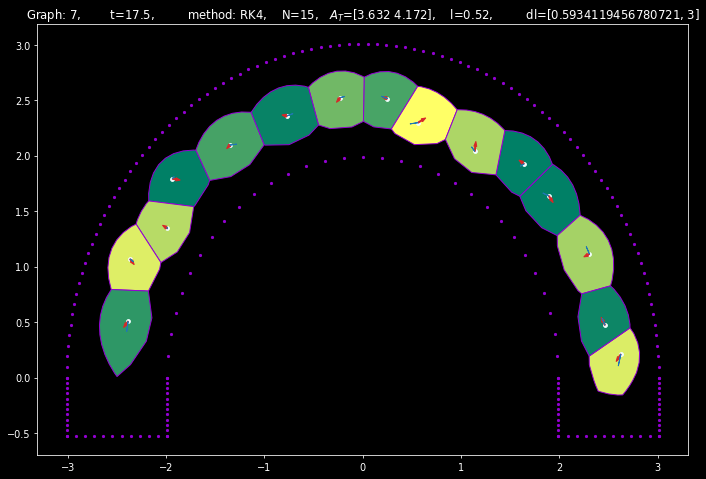

evolve_voronoi:  20.0
	T0: -33.06589592463827


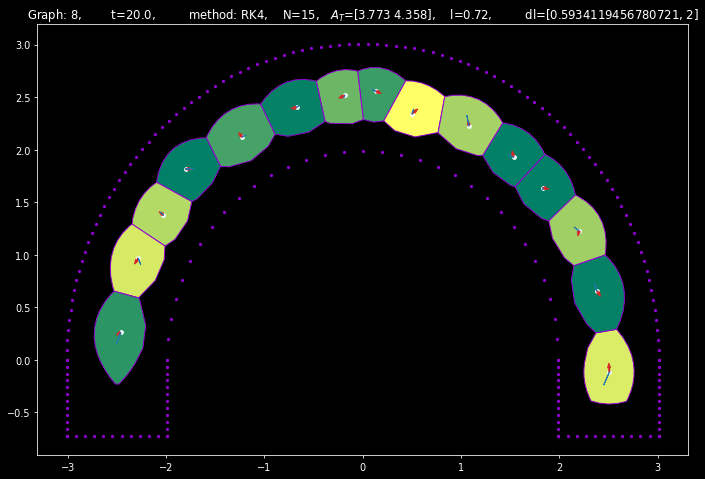

evolve_voronoi:  22.5
	T0: -36.01111907483494


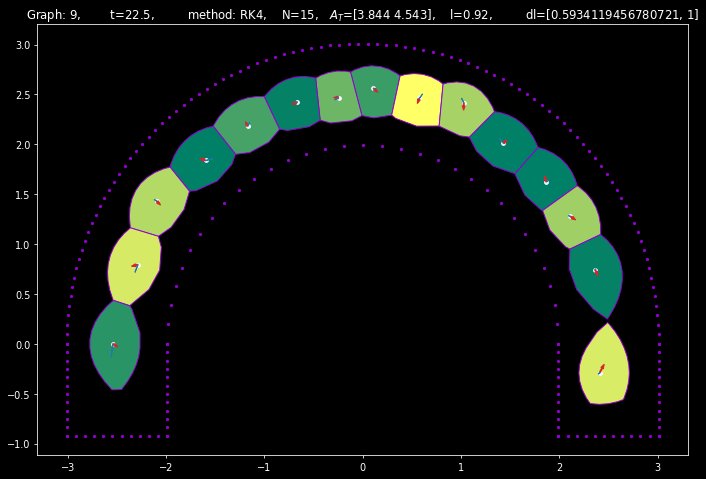

KeyboardInterrupt: ignored

In [83]:
N = 15; l = 0.0;    kN = N/(N+1)
r = np.array([2, 3]); theta = np.array([0, np.pi]); e = 0.0
step = 0.01; lenght = 250; tol = 0.01

K, params = [0.0004, 0.521, 0.1], [50, 100, 30]            #alpha, beta, gamma
C0 = np.random.rand(N)
pts_structure2 = get_structure(r, theta, e, l, 100, tol=tol)
pts_rand2 = rand_points(r, theta, e, N, tol=tol).T
vor2 = mk_voronoi(pts_rand2, pts_structure2)

filenames = []
evolve_vornonoi(r, theta, l, K, vor2, C0, N, params, step=step, lenght=lenght, iter=500, vel=(0,0.01), method="RK4", A_fixed= kN*A_total(r, l), 
                scale=1/2, filenames=filenames, state=False, celldiv=False, l_step=3)

In [ ]:
print("Porcentaje de área utilizada:\t", 3.5481/3.7753*100, "%")
print("Área promedio de célula:\t", 3.5481/N)
print("\t\t\t\t",3.5481*(1+1/N),", ", 3.7753)

In [ ]:
1/0.9398

In [ ]:
with imageio.get_writer(f'/content/drive/MyDrive/biomath_model/VoronoiCells_with_ATDiv_N{N}_K{K}.gif', fps=20) as writer:    # inputs: filename, frame per second
    for filename in filenames:
        image = imageio.imread(filename)                         # load the image file
        writer.append_data(image)                                # append the image file
print('Gif saved!\n')